In [57]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import glob
import os
import sys
import scipy.ndimage
import imageio

In [23]:
sys.path.append('../../Preprocess/')
import CalcParaMaps

In [7]:
iTests = np.arange(55,70)
imgNorm = 0.15

In [8]:
# read references
with np.load('/home/dwu/trainData/Noise2Noise/train/ctp/simul/data/paras_tikh_0.3.npz') as f:
    mask = f['mask'][iTests, ...]
    cbfFac = f['cbfFac']
    cbvFac = f['cbvFac']
aif = np.load('/home/dwu/trainData/Noise2Noise/train/ctp/simul/data/aif0.npy') / 1000 / imgNorm
ref = (np.load('/home/dwu/trainData/Noise2Noise/train/ctp/simul/data/imgs_-1.npy')[iTests, ...] - 1) / imgNorm
img = (np.load('/home/dwu/trainData/Noise2Noise/train/ctp/simul/data/imgs_200000.npy')[iTests, ...] - 1) / imgNorm

In [9]:
# vessel mask from img
maskVessels = np.where(np.max(img, -1) > 0.1 / imgNorm, 1, 0)
maskVessels *= mask
for i in range(maskVessels.shape[0]):
    maskVessels[i,...] = scipy.ndimage.morphology.binary_dilation(maskVessels[i,...])
mask *= (1-maskVessels)

img *= mask[...,np.newaxis]
ref *= mask[...,np.newaxis]
ctp = img - (img[...,[0]] + img[...,[1]]) / 2
refCtp = ref - ref[...,[0]]

In [11]:
# pre-process to get target frames
avg = np.copy(img)
for i in range(1, avg.shape[-1] - 1):
    avg[...,i] = (img[...,i-1] + img[...,i+1]) / 2

In [14]:
x = np.sum(avg * mask[...,np.newaxis], (1,2))
y = np.sum(img * mask[...,np.newaxis], (1,2))
p = y / x
cavg = avg * p[:, np.newaxis, np.newaxis, :]

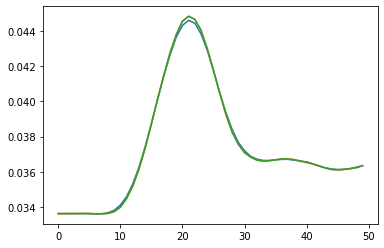

In [20]:
plt.plot(np.mean(avg, (0,1,2)))
plt.plot(np.mean(cavg, (0,1,2)))
plt.plot(np.mean(img, (0,1,2)))

In [24]:
# paramaps for reference
cbf0, cbv0, mtt0, ttp0 = GetResults(refCtp, aif, mask, cbfFac, cbvFac)

In [25]:
def GetResults(ctp, aif, mask, cbfFac, cbvFac):
    cbf, cbv, mtt = CalcParaMaps.CalcParaMaps(ctp, mask[...,np.newaxis], kappa = 1, rho = 1, aif = np.copy(aif), directCBV = False)
    cbf *= cbfFac
    cbv *= cbvFac
    mtt = mtt / cbfFac * cbvFac
    ttp = np.argmax(ctp, -1)
    
    return cbf * mask, cbv * mask, mtt * mask, ttp * mask

In [29]:
def RMSE(src, ref, mask, th = None):
    if th is not None:
        src[src < th[0]] = th[0]
        src[src > th[1]] = th[1]
    return np.sqrt(np.sum((src - ref)**2 * mask) / np.sum(mask))

In [32]:
# select beta for Noise2Noise
filenames = glob.glob('/home/dwu/trainData/Noise2Noise/train/ctp/simul/beta_*_N0_*/tmp/iodines.npy')
n2ns = {}
cbfs = {}
for filename in filenames:
    print (filename)
    tokens = filename.split('/')[-3].split('_')
    
    beta = float(tokens[1])
    N0 = float(tokens[3])
    
    n2n = np.load(filename)[iTests, ...].transpose(0, 2, 3, 1) * 0.025 / imgNorm
    cbf, cbv, mtt, ttp = GetResults(n2n, aif, mask, cbfFac, cbvFac)
    
    if N0 not in n2ns:
        n2ns[N0] = []
    n2ns[N0].append([beta, RMSE(cbf, cbf0, mask), RMSE(cbv, cbv0, mask), RMSE(mtt, mtt0, mask, [0,10])])
    
    if N0 not in cbfs:
        cbfs[N0] = {}
    cbfs[N0][beta] = cbf
        
for N0 in n2ns:
    vals = np.array(n2ns[N0])
    inds = np.argsort(vals[:, 0])
    n2ns[N0] = vals[inds, :]

/home/dwu/trainData/Noise2Noise/train/ctp/simul/beta_50_N0_200000/tmp/iodines.npy
/home/dwu/trainData/Noise2Noise/train/ctp/simul/beta_25_N0_200000/tmp/iodines.npy
/home/dwu/trainData/Noise2Noise/train/ctp/simul/beta_0_N0_200000/tmp/iodines.npy
/home/dwu/trainData/Noise2Noise/train/ctp/simul/beta_12.5_N0_200000/tmp/iodines.npy
/home/dwu/trainData/Noise2Noise/train/ctp/simul/beta_37.5_N0_200000/tmp/iodines.npy
/home/dwu/trainData/Noise2Noise/train/ctp/simul/beta_25_N0_1e+06/tmp/iodines.npy
/home/dwu/trainData/Noise2Noise/train/ctp/simul/beta_0_N0_1e+06/tmp/iodines.npy
/home/dwu/trainData/Noise2Noise/train/ctp/simul/beta_50_N0_1e+06/tmp/iodines.npy
/home/dwu/trainData/Noise2Noise/train/ctp/simul/beta_12.5_N0_1e+06/tmp/iodines.npy
/home/dwu/trainData/Noise2Noise/train/ctp/simul/beta_37.5_N0_1e+06/tmp/iodines.npy
/home/dwu/trainData/Noise2Noise/train/ctp/simul/beta_50_N0_100000/tmp/iodines.npy
/home/dwu/trainData/Noise2Noise/train/ctp/simul/beta_25_N0_100000/tmp/iodines.npy
/home/dwu/train

In [50]:
outDir = '/home/dwu/trainData/Noise2Noise/train/ctp/results/simul/beta'
if not os.path.exists(outDir):
    os.makedirs(outDir)

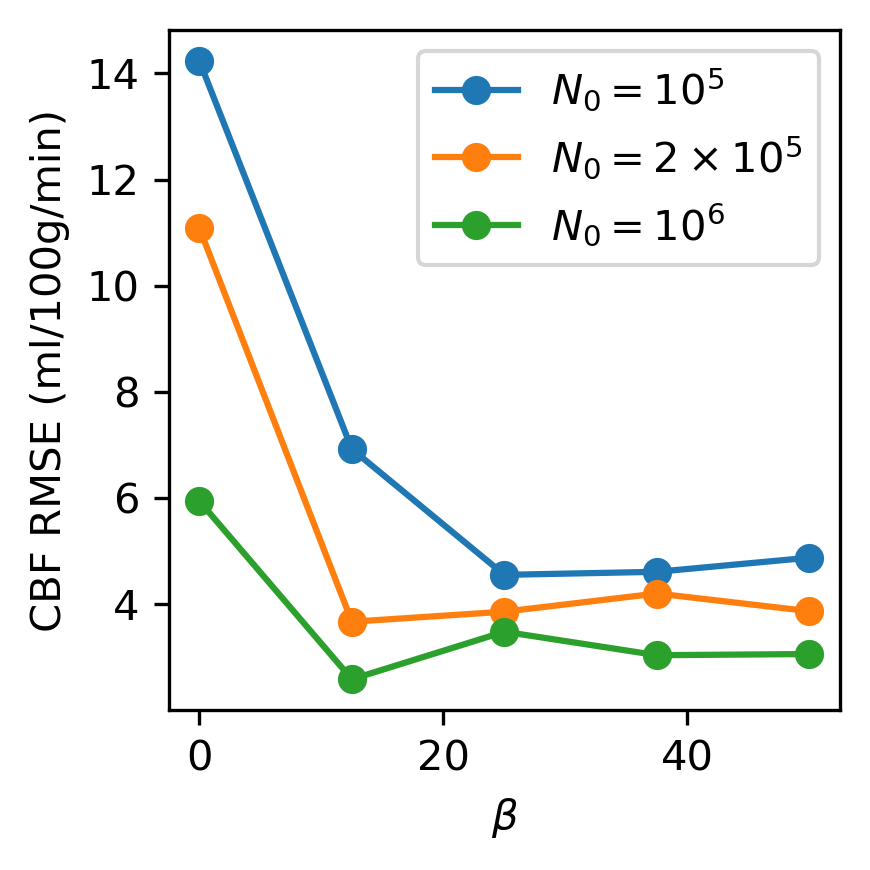

In [52]:
N0s = [100000, 200000, 1e+06]
plt.figure(figsize=[3,3], dpi=300)
for N0 in N0s:
    plt.plot(n2ns[N0][:,0], n2ns[N0][:,1], 'o-')
plt.legend(['$N_0=10^5$', '$N_0=2\\times10^5$', '$N_0=10^6$'])
plt.xlabel('$\\beta$')
plt.ylabel('CBF RMSE (ml/100g/min)')
plt.tight_layout()
plt.savefig(os.path.join(outDir, 'cbf_beta_rmse.png'))

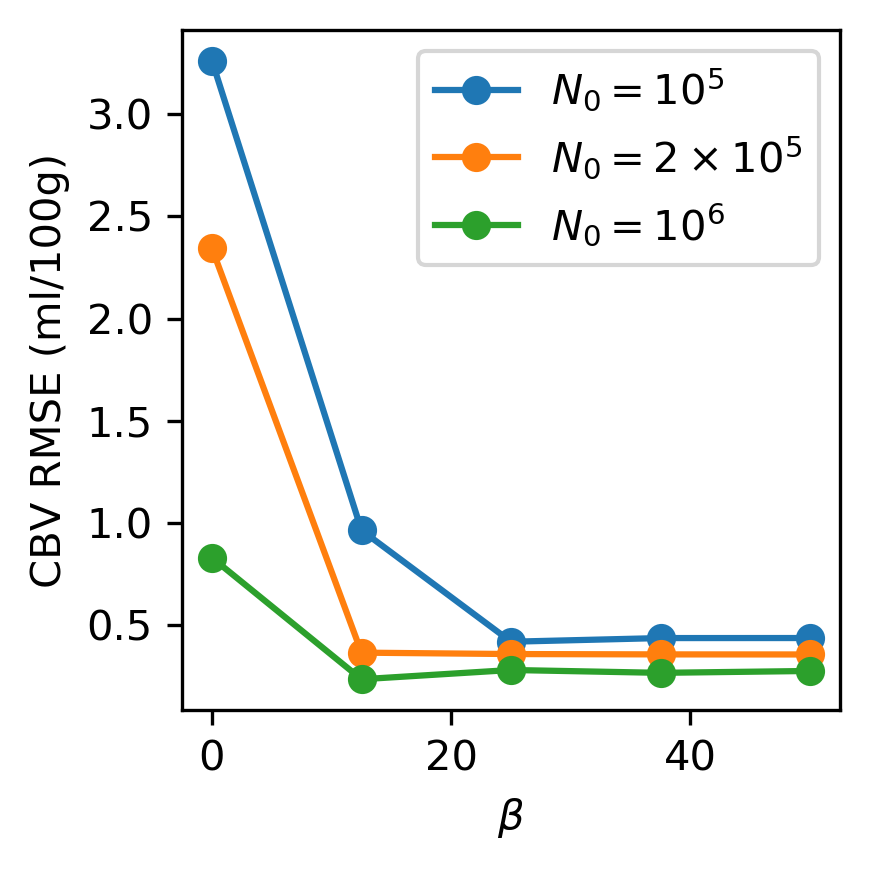

In [53]:
plt.figure(figsize=[3,3], dpi=300)
for N0 in N0s:
    plt.plot(n2ns[N0][:,0], n2ns[N0][:,2], 'o-')
plt.legend(['$N_0=10^5$', '$N_0=2\\times10^5$', '$N_0=10^6$'])
plt.xlabel('$\\beta$')
plt.ylabel('CBV RMSE (ml/100g)')
plt.tight_layout()
plt.savefig(os.path.join(outDir, 'cbv_beta_rmse.png'))

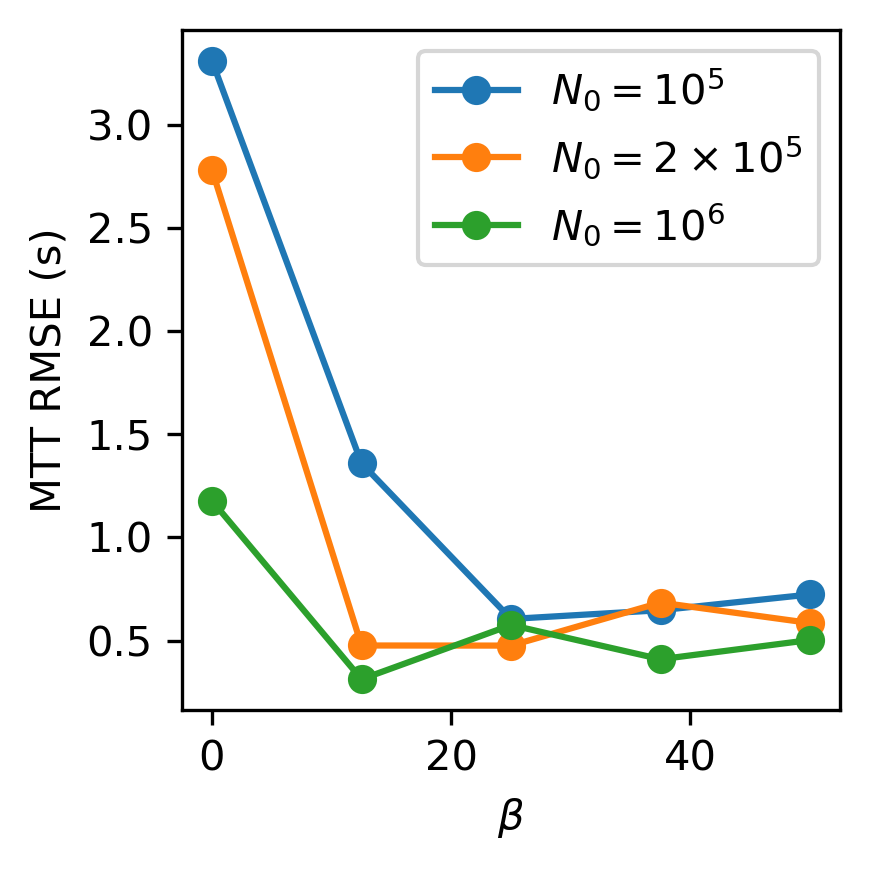

In [54]:
plt.figure(figsize=[3,3], dpi=300)
for N0 in N0s:
    plt.plot(n2ns[N0][:,0], n2ns[N0][:,3], 'o-')
plt.legend(['$N_0=10^5$', '$N_0=2\\times10^5$', '$N_0=10^6$'])
plt.xlabel('$\\beta$')
plt.ylabel('MTT RMSE (s)')
plt.tight_layout()
plt.savefig(os.path.join(outDir, 'mtt_beta_rmse.png'))

In [58]:
# the CBF images
cmap = matplotlib.cm.jet(np.arange(256))
cmap[0, :-1] = 0
newCmap = matplotlib.colors.ListedColormap(cmap, 'perfusion', N=256)

In [59]:
def SaveImg(filename, img, cmap, vmin, vmax):
    img = (img - vmin) / (vmax - vmin) * 255
    img[img < 0] = 0
    img[img > 255] = 255
    img = cmap(img.astype(np.uint8)) * 255
    img = img.astype(np.uint8)
    
    if filename is not None:
        imageio.imwrite(filename, img)
        
    return img

In [66]:
N0 = 100000
for beta in cbfs[N0]:
    _ = SaveImg(os.path.join(outDir, 'cbf_beta_%g_100000.png'%beta), cbfs[N0][beta][0,32:-32,32:-32], newCmap, 0, 50)